This notebook is a vewrsion of the original notebook. Instead of preparing the data by padding and masking smaller batches of time series of the trajectories are prepared and fed to the network

Notebook for the GoogleDecimeterChallenge https://www.kaggle.com/competitions/smartphone-decimeter-2023


Also try to run it on google collab, works great only RAM is limited:
https://colab.research.google.com/github/Torbynator/GoogleDecimeterChallenge/blob/main/main.ipynb#scrollTo=TOn-Can4C0YP

#Only for google collab
from google.colab import drive
drive.mount('/content/drive')
!pip install  kaggle
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!kaggle competitions download -c smartphone-decimeter-2023
!unzip /content/smartphone-decimeter-2023.zip

In [1]:
#reading data
import numpy as np 
import pandas as pd
from tqdm import tqdm, trange
import math
import os
import tensorflow as tf
import matplotlib.pyplot as plt	

INPUT_PATH = 'sdc2023/'



In [2]:


# test_input_data = []
# test_gt_data = []

# #iterate over all data files and store them in the respective arrays

# #load test data
# test_files = os.listdir(INPUT_PATH + "test")

# for folder in test_files:
#     smartphones = os.listdir(INPUT_PATH + "test/"+folder)
#     for smartphone in smartphones:
#         file =  "/device_gnss.csv"
#         #store data in list while dropping first and 41st column (string data)
#         test_input_data.append(pd.read_csv(INPUT_PATH + "test/" +folder+"/"+smartphone + file, usecols=[i for i in range(58) if i not in [0,40]], dtype=np.float32).to_numpy(dtype=np.float32).tolist())


In [3]:
#load train data
MAX_TRAJECTORIES = 1
train_files = os.listdir(INPUT_PATH + "train")
trajectory_count=0
used_columns = ["utcTimeMillis","RawPseudorangeMeters", "RawPseudorangeUncertaintyMeters" ,"SvPositionXEcefMeters" ,"SvPositionYEcefMeters", "SvPositionZEcefMeters", "IsrbMeters"]

train_input_data = []
train_gt_data = []

for folder in train_files:
    smartphones = os.listdir(INPUT_PATH + "train/"+folder)
    for smartphone in smartphones:
        files = os.listdir(INPUT_PATH + "train/"+folder+"/"+smartphone)
        for file in files:
            if file.endswith(".csv"):
                if trajectory_count >= MAX_TRAJECTORIES:
                    break   
                if "gnss" in file:
                    #store data in list while dropping first and 41st column (string data), as well as (porbably mostly) empty columns
                    #also all data points with the same timestep are seen as features of one timestep of a sample
                    sample = pd.read_csv(INPUT_PATH + "train/" +folder+"/"+ smartphone+ "/" + file, usecols=used_columns, dtype=float).to_numpy(dtype=float)
                    #correct PseudoRange with ISRB
                    sample[:,1] = sample[:,1] + sample[:,6]
                    train_input_data.append(sample)
                elif "ground_truth" in file:
                    trajectory_count +=1
                    #store data in list while dropping first and 2nd column (string data),(porbably mostly) empty columns
                    train_gt_data.append(pd.read_csv(INPUT_PATH + "train/"+folder+"/" + smartphone+ "/" + file,  usecols=[i for i in range(9) if i not in [0,1]], dtype=float).to_numpy(dtype=float).tolist())
                    print(f"read in {trajectory_count} samples")

#delete IRSB column
train_input_data = [sample[:,:6] for sample in train_input_data]

#replace NaN values with 0
train_input_data = [[[0 if math.isnan(x) else x for x in timestep] for timestep in sample ] for sample in train_input_data]

read in 1 samples


In [4]:
TIME_SERIES_SIZE = 50
import json


#move all features with the same timestamp to one line 
for sample in range(len(train_input_data)):
    matches = 0
    print(f"sample {sample}")
    timesteps = 0
    for step in range(len(train_input_data[sample])):
        if step != 0:
            if train_input_data[sample][step-matches][0] == train_input_data[sample][step-1-matches][0]:
                train_input_data[sample][step-1-matches].extend(train_input_data[sample][step-matches][1:])
                train_input_data[sample].pop(step-matches)
                matches +=1
            else:
                timesteps+=1


#prpare batches of time series of size TIME_SERIES_SIZE
train_input_data_batched = [sample[i:i+TIME_SERIES_SIZE] for sample in train_input_data for i in range(0,len(sample)-TIME_SERIES_SIZE)]
train_gt_data_batched = [sample[i:i+TIME_SERIES_SIZE] for sample in train_gt_data for i in range(0,len(sample)-TIME_SERIES_SIZE)]




#pad input data
max_features = max(max([len(feature) for sample in train_input_data_batched for feature in sample]),max([len(feature) for sample in train_gt_data_batched for feature in sample]))


train_input_data_padded = [tf.keras.preprocessing.sequence.pad_sequences(sample,value=0, padding="post", dtype=np.float64, maxlen=max_features) for sample in train_input_data_batched]
train_input_data_padded = np.array(train_input_data_padded)



del train_input_data, train_input_data_batched

#pad ground truth data
max_features_gt = max(len(feature) for sample in train_gt_data_batched for feature in sample)

#convert to right data format
train_gt_data_padded = [tf.keras.preprocessing.sequence.pad_sequences(sample, value=0,padding="post", dtype=np.float64, maxlen=max_features_gt) for sample in train_gt_data_batched]
train_gt_data_padded = np.array(train_gt_data_padded)
del train_gt_data, train_gt_data_batched

if(train_input_data_padded.shape[0] != train_gt_data_padded.shape[0]):
    while train_input_data_padded.shape[0] > train_gt_data_padded.shape[0]:
        train_input_data_padded = np.delete(train_input_data_padded, -1, axis=0)
    while train_input_data_padded.shape[0] < train_gt_data_padded.shape[0]:
        train_gt_data_padded = np.delete(train_gt_data_padded, -1, axis=0)

print(train_input_data_padded.shape)
print(train_gt_data_padded.shape)


sample 0
(1249, 50, 211)
(1249, 50, 7)


In [5]:
import sklearn.preprocessing as preprocess

#normalize data
scaler = preprocess.MinMaxScaler()
train_input_data_padded_normalized = []
for sample in train_input_data_padded:
    data_range = []
    train_input_data_padded_normalized.append(scaler.fit_transform(sample))
train_input_data_padded_normalized=np.array(train_input_data_padded_normalized)

gt_scaler = preprocess.MinMaxScaler()
train_gt_data_padded_normalized = []
for sample in train_gt_data_padded:
    data_range = []
    train_gt_data_padded_normalized.append(gt_scaler.fit_transform(sample))
train_gt_data_padded_normalized=np.array(train_gt_data_padded_normalized)


In [16]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam


ACTIVATION = "tanh"

clear_session()



#create model
model = Sequential()
model.add(Masking(mask_value=0, input_shape=(train_input_data_padded.shape[1], train_input_data_padded.shape[2])))
#model.add(tf.keras.layers.BatchNormalization(axis=-1, input_shape=(train_input_data_padded.shape[1], train_input_data_padded.shape[2])))
model.add(LSTM(50,activation=ACTIVATION ,return_sequences=True))
model.add(LSTM(50, activation=ACTIVATION ,return_sequences=True))
model.add(Dense(7, activation="linear"))


def measure(lat1, lon1, lat2, lon2):  # generally used geo measurement function
    R = 6378.137; # Radius of earth in KM
    dLat = lat2 * np.pi / 180 - lat1 * np.pi / 180
    dLon = lon2 * np.pi / 180 - lon1 * np.pi / 180
    a = np.sin(dLat/2) * np.sin(dLat/2) + np.cos(lat1 * np.pi / 180) * np.cos(lat2 * np.pi / 180) *  np.sin(dLon/2) * np.sin(dLon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c
    return d * 10000; #decimeters


class DecimeterError(tf.keras.callbacks.Callback):
    def __init__(self):
        super(DecimeterError, self).__init__()

    def on_epoch_end(self, epoch, logs=None):
        ly_pred = self.model.predict(train_input_data_padded_normalized)
        ly_true = train_gt_data_padded_normalized
        ly_pred = np.array([gt_scaler.inverse_transform(sample) for sample in ly_pred])
        ly_true = np.array([gt_scaler.inverse_transform(sample) for sample in ly_true])
        error = measure(ly_pred[:,:,0], ly_pred[:,:,1], ly_true[:,:,0], ly_true[:,:,1])
        total_avg_error = np.mean(error)
        print(f"decimeter error: {total_avg_error}")



model.compile(optimizer="adam", loss="MeanSquaredError")


d:\OneDrive\Documents\Uni\Machine Learning in Mechanics\GoogleDecimeterChallenge\.venv\Lib\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 50, 211)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50, 50)         │        52,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50, 7)          │           357 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,957 (284.99 KB)

 Trainable params: 72,957 (284.99 KB)

 Non-trainable params: 0 (0.00 B)

None


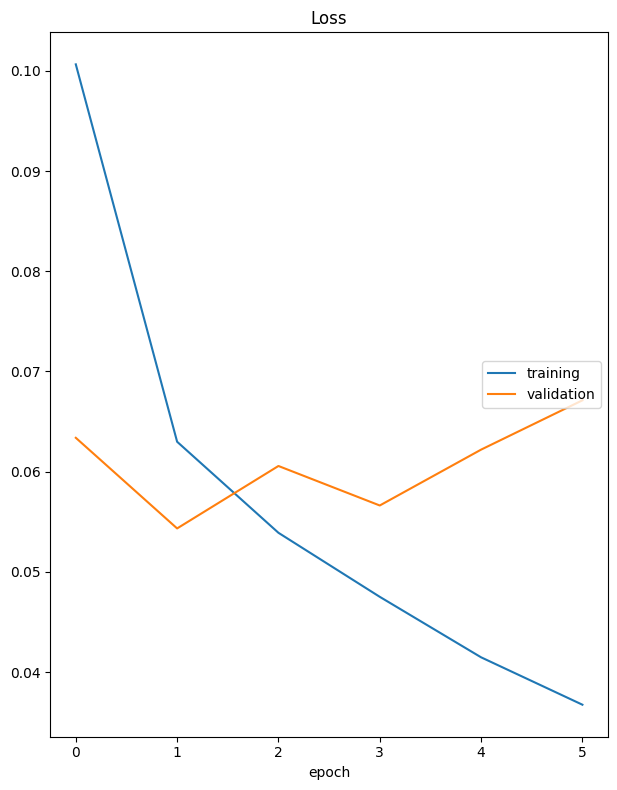

Loss
	training         	 (min:    0.037, max:    0.101, cur:    0.037)
	validation       	 (min:    0.054, max:    0.067, cur:    0.067)
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
(1249, 50) (1249, 50) (1249, 50) (1249, 50)
decimeter error: 265.29027737362503
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0373 - val_loss: 0.0671
Epoch 7/100
13/32 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0344

KeyboardInterrupt: 

In [18]:
from livelossplot import PlotLossesKeras


# train the model
history = model.fit(train_input_data_padded_normalized, train_gt_data_padded_normalized, epochs=100, batch_size=32, validation_split=0.2, callbacks=[PlotLossesKeras(), DecimeterError()])



In [12]:
prediction = gt_scaler.inverse_transform(model.predict(train_input_data_padded_normalized[0:1])[0])
print(prediction)
print(prediction.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[ 3.75865974e+01 -1.22329926e+02 -2.93883286e+01  7.91503048e+00
   8.23022649e-02  1.29313766e+02  1.59304660e+12]
 [ 3.75869980e+01 -1.22329979e+02 -2.93160439e+01  8.77297211e+00
   7.20181242e-02  1.43518570e+02  1.59304660e+12]
 [ 3.75872383e+01 -1.22330002e+02 -2.92903080e+01  7.30015421e+00
   6.39279634e-02  1.44048553e+02  1.59304660e+12]
 [ 3.75874214e+01 -1.22329842e+02 -2.92051907e+01  5.65490294e+00
   6.80344999e-02  2.17125854e+02  1.59304660e+12]
 [ 3.75874672e+01 -1.22329781e+02 -2.91781330e+01  3.76105714e+00
   7.53549635e-02  2.79636688e+02  1.59304660e+12]
 [ 3.75874214e+01 -1.22329803e+02 -2.91944885e+01  2.20890951e+00
   7.78426230e-02  2.97802887e+02  1.59304660e+12]
 [ 3.75873680e+01 -1.22329819e+02 -2.92160263e+01  2.06228280e+00
   8.22711289e-02  3.12295532e+02  1.59304660e+12]
 [ 3.75873070e+01 -1.22329842e+02 -2.92232800e+01  3.13249898e+00
   8.79704952e-02  3.17573151e+02  1.59304660e+12]
 [ 3.75872650e+01 -1.22329